# **7. Деревья решений и случайный лес. Практика**

✍ Настало время попрактиковаться в использовании деревьев решений и случайного леса для решения задачи классификации.

Продолжим решение задачи об оттоке клиентов банка, которую мы решали в юните 4. Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

→ Теперь попробуем решить задачу с помощью деревьев решений и лесов.

Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.

Поэтому для решения задачи используйте обучающую (X_train, y_train) и тестовую (X_test, y_test) выборки без полиномиальных столбцов.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [2]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Для удобства переобозначим целевой признак (не обязательный шаг)

In [3]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [4]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

Предобрабатываем категориальные признаки: уменьшаем количество категорий

In [5]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Wife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [6]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [7]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Кодируем текстовые категориальные признаки

In [8]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [9]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [11]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [12]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [13]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19775
           1       0.72      0.58      0.64      6273

    accuracy                           0.84     26048
   macro avg       0.80      0.75      0.77     26048
weighted avg       0.84      0.84      0.84     26048

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4945
           1       0.72      0.58      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



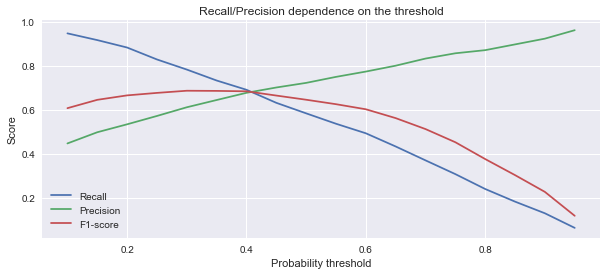

In [14]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [15]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4945
           1       0.68      0.69      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.79      0.79      6513
weighted avg       0.85      0.85      0.85      6513



## Задание 7.1

Обучите на обучающей выборке дерево решений с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона. Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Сделайте предсказания для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

In [18]:
from sklearn import tree


dt = tree.DecisionTreeClassifier(
    max_depth=8, 
    criterion='entropy', 
    random_state=42,
    min_samples_leaf=10
)
 
dt.fit(X_train, y_train)
 
y_train_pred= dt.predict(X_train)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
 
y_test_pred = dt.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train F1: 0.66
Test F1: 0.64


Задание 7.2

In [19]:
from sklearn import ensemble
 
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy', 
    min_samples_leaf=10,
    random_state=42
)
 
rf.fit(X_train, y_train)
 
y_train_pred= rf.predict(X_train)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
 
y_test_pred = rf.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train F1: 0.63
Test F1: 0.63


Задание 7.4

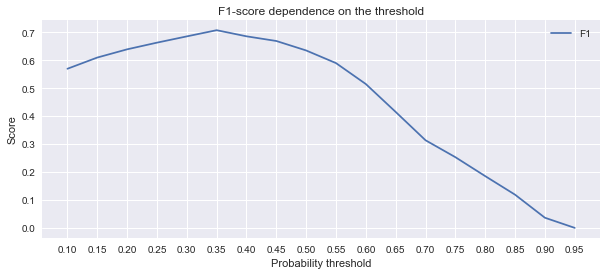

In [20]:
y_test_proba_pred = pd.Series(rf.predict_proba(X_test)[:, 1])
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, f1_scores, label='F1')
ax.set_title('F1-score dependence on the threshold')
ax.set_xticks(thresholds) 
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

Задание 7.5

In [21]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35
#Клиентов, для которых вероятность ухода > 0.35, относим к классу 1
#В противном случае — к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

Test F1: 0.71


# **8. Итоги**

✍ В этом модуле мы рассмотрели, как решается задача классификации. Стоит отметить, что эта задача является более популярной, но в то же время более сложной, чем задача регрессии, о которой мы говорили ранее.

Мы рассмотрели самые популярные модели и подходы, которые позволяют решать задачу классификации, а также их реализацию.

Подведём итоги модуля.

**В этом модуле мы:**

+ узнали, что такое модель логистической регрессии и как она связана с задачей регрессии, несмотря на то что она решает задачу классификации;
+ рассмотрели реализацию логистической регрессии в sklearn и научились с её помощью делать предсказания классов и оценок вероятностей принадлежностей к каждому из классов;
+ познакомились с основными метриками классификации и научились оценивать качество классификатора;
+ узнали, как бинарная классификация обобщается на случай мультиклассовой классификации и научились решать такие задачи;
+ познакомились с деревьями решений и узнали, как происходит их построение;
+ рассмотрели реализацию модели дерева решений в sklearn и научились с её помощью делать предсказания классов и оценок вероятностей;
+ сделали свои первые шаги на пути к освоению ансамблевых моделей на примере бэггинга и обсудили принципы его работы;
+ рассмотрели реализацию случайного леса (Random Forest) и научились с его помощью делать предсказания классов и оценок вероятностей;
+ с помощью всех рассмотренных моделей решили настоящую бизнес-задачу классификации и даже оценили качество её решения.

**Методы решения задачи классификации, которые мы рассмотрели в модуле:**

+ LogisticRegression — модель логистической регрессии;
+ PolynomialFeatures + LogisticRegression — модель полиномиальной логистической регрессии (или логистическая регрессия на полиномиальных признаках);
+ DecisionTreeClassifier — модель дерева решений для классификации;
+ RandomForestClassifier — случайный лес (бэггинг над деревьями решений + метод случайных подпространств).

Отметим, что, помимо рассмотренных методов классификации, существует ещё множество методов, с которыми мы будем знакомиться и дальше.